# Problem 4.4

## part a

In [4]:
qui import delim "./data/chapter04/GerberGreenBook_Chapter4_Exercises_4-5.csv",clear
set seed 1234567

In [5]:
rename d D	
regress y D	
qui summ y if D==1, meanonly
scalar treat_mean = r(mean)
qui summ y if D==0, meanonly
scalar control_mean = r(mean)




      Source |       SS           df       MS      Number of obs   =        40
-------------+----------------------------------   F(1, 38)        =      5.16
       Model |      1144.9         1      1144.9   Prob > F        =    0.0288
    Residual |      8427.5        38  221.776316   R-squared       =    0.1196
-------------+----------------------------------   Adj R-squared   =    0.0964
       Total |      9572.4        39  245.446154   Root MSE        =    14.892

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           D |       10.7   4.709313     2.27   0.029     1.166494    20.23351
       _cons |      26.85   3.329987     8.06   0.000     20.10879    33.59121
------------------------------------------------------------------------------






In [6]:
disp "ATE =" treat_mean - control_mean

global tau = treat_mean - control_mean


ATE =10.7



## part b

In [7]:
qui regress y x if D==1
local co_treat = _b[x]
qui regress y x if D==0
local co_control= _b[x]
disp "Sum of Coefficients = "`co_treat' + `co_control'






Sum of Coefficients = 1.8460607


In [8]:
qui gen ydiff = y - x
regress ydiff D




      Source |       SS           df       MS      Number of obs   =        40
-------------+----------------------------------   F(1, 38)        =      8.93
       Model |     235.225         1     235.225   Prob > F        =    0.0049
    Residual |     1000.55        38  26.3302632   R-squared       =    0.1903
-------------+----------------------------------   Adj R-squared   =    0.1690
       Total |    1235.775        39  31.6865385   Root MSE        =    5.1313

------------------------------------------------------------------------------
       ydiff |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           D |       4.85    1.62266     2.99   0.005     1.565096    8.134904
       _cons |         -1   1.147394    -0.87   0.389    -3.322778    1.322778
------------------------------------------------------------------------------


## part c

In [9]:
regress y D x
global tau_c = _b[D]



      Source |       SS           df       MS      Number of obs   =        40
-------------+----------------------------------   F(2, 37)        =    168.97
       Model |  8627.78597         2  4313.89298   Prob > F        =    0.0000
    Residual |  944.614033        37   25.530109   R-squared       =    0.9013
-------------+----------------------------------   Adj R-squared   =    0.8960
       Total |      9572.4        39  245.446154   Root MSE        =    5.0527

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           D |   5.315536   1.628474     3.26   0.002     2.015935    8.615138
           x |   .9204212   .0537624    17.12   0.000     .8114883    1.029354
       _cons |   1.216271   1.875729     0.65   0.521    -2.584317    5.016858
-------------------------------------------------

## part d

In [10]:
capture program drop ate
program define ate, rclass
	regress y D
    return scalar Ys=_b[D]
end

tsrtest D r(Ys) using ate.dta, overwrite: ate




Two-sample randomization test for theta=r(Ys) of ate by D

Combinations:   137846528820 = (40 choose 20)
Assuming null=0
Observed theta: 10.7

Minimum time needed for exact test (h:m:s):  161969:40:17
Reverting to Monte Carlo simulation.
Mode: simulation (10000 repetitions)

progress: |........................................|

 p=0.01490 [one-tailed test of Ho:  theta(D==0)<=theta(D==1)]
 p=0.98600 [one-tailed test of Ho:  theta(D==0)>=theta(D==1)]
 p=0.03110 [two-tailed test of Ho:  theta(D==0)==theta(D==1)]

Saving log file to ate.dta...done.


In [11]:
//ate
di r(obsvStat)

10.7


In [12]:
// p.value
di r(twotail) 

.03109689






(1 observation deleted)


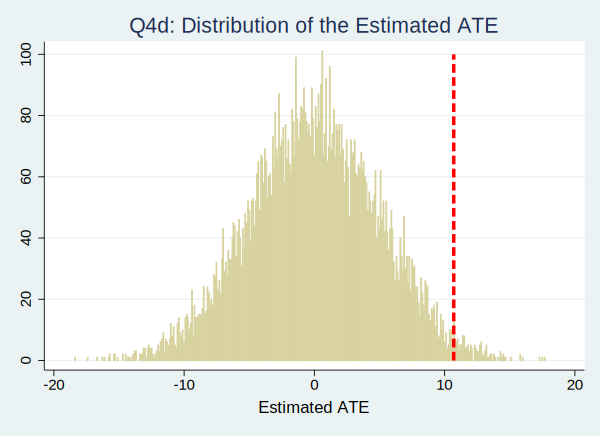





(file ./exercise_4_4_d_graph.pdf written in PDF format)



In [16]:
preserve
//historgam
use "ate.dta", clear
global tau =  theta[1]
drop if _n==1

graph twoway (histogram theta,frequency bin(1000)) ///
(scatteri 0 $tau 100 $tau, c(l) lc(red) lw(thick) lp(dash) m(i)), legend(off) ///
b1title("Estimated ATE") title("Q4d: Distribution of the Estimated ATE") ///
xtitle("")

graph export ./exercise_4_4_d_graph.pdf

restore

## part e

In [13]:
capture program drop ate_cov
program define ate_cov, rclass
	regress y D x
    return scalar Ys=_b[D]
end

tsrtest D r(Ys) using ate_cov.dta, overwrite: ate_cov




Two-sample randomization test for theta=r(Ys) of ate_cov by D

Combinations:   137846528820 = (40 choose 20)
Assuming null=0
Observed theta: 5.316

Minimum time needed for exact test (h:m:s):  164458:34:01
Reverting to Monte Carlo simulation.
Mode: simulation (10000 repetitions)

progress: |........................................|

 p=0.00150 [one-tailed test of Ho:  theta(D==0)<=theta(D==1)]
 p=0.99840 [one-tailed test of Ho:  theta(D==0)>=theta(D==1)]
 p=0.00290 [two-tailed test of Ho:  theta(D==0)==theta(D==1)]

Saving log file to ate_cov.dta...done.


In [14]:
//ate_cov
di r(obsvStat)

5.3155362


In [15]:
// p.value_cov
di r(twotail) 

.00289971


## part f

In [17]:
cap drop Y0_sim Y1_sim Y_sim
qui gen Y0_sim = y
qui gen Y1_sim = y
qui gen Y_sim = .
qui replace Y0_sim = y - $tau if D==1
qui replace Y1_sim = y + $tau if D==0

In [19]:
capture program drop ate_null
program define ate_null, rclass
	replace Y_sim = Y0_sim*(1-D) + Y1_sim*(D) 
	regress Y_sim D 
    return scalar Ys=_b[D]	
end

ritest D Ys = r(Ys), reps(10000) sav(ate_null.dta, replace) nodots: ate_null




(40 real changes made)

      Source |       SS           df       MS      Number of obs   =        40
-------------+----------------------------------   F(1, 38)        =      5.16
       Model |      1144.9         1      1144.9   Prob > F        =    0.0288
    Residual |      8427.5        38  221.776316   R-squared       =    0.1196
-------------+----------------------------------   Adj R-squared   =    0.0964
       Total |      9572.4        39  245.446154   Root MSE        =    14.892

------------------------------------------------------------------------------
       Y_sim |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           D |       10.7   4.709313     2.27   0.029     1.166494    20.23351
       _cons |      26.85   3.329987     8.06   0.000     20.10879    33.59121
------------------------------------------------------------------------------

      command:  ate_nul



(ritest D : ate_null)




95%CI: (1.53, 19.83)


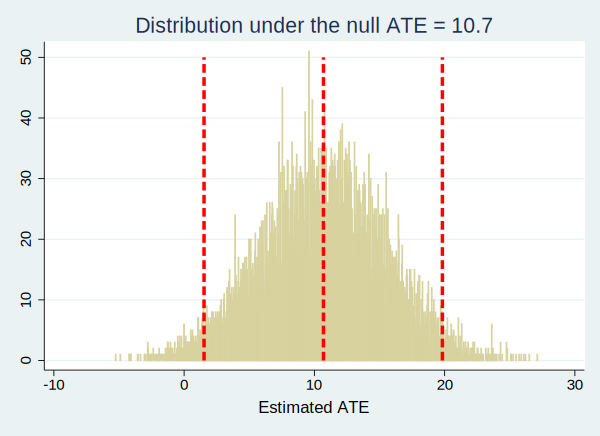





(file ./exercise_4_4_f_graph.pdf written in PDF format)



In [20]:
preserve
// CI and Hist
use "ate_null.dta", clear

sort Ys
global ylower= round(Ys[251], .01)

global yupper= round(Ys[9750], .01)
di "95%CI: ($ylower, $yupper)" 

graph twoway (histogram Ys,frequency bin(1000)) ///
(scatteri 0 $tau 50 $tau, c(l) lc(red) lw(thick) lp(dash) m(i)) ///
(scatteri 0 $ylower 50 $ylower, c(l) lc(red) lw(thick) lp(dash) m(i)) ///
(scatteri 0 $yupper 50 $yupper, c(l) lc(red) lw(thick) lp(dash) m(i)), ///
legend(off) ///
b1title("Estimated ATE") title("Distribution under the null ATE = 10.7") ///
xtitle("")

graph export ./exercise_4_4_f_graph.pdf

restore

## part g

In [21]:
cap drop Y0_sim Y1_sim Y_sim
qui gen Y0_sim = y
qui gen Y1_sim = y
qui gen Y_sim = .
qui replace Y0_sim = y - $tau_c if D==1
qui replace Y1_sim = y + $tau_c if D==0

In [22]:
capture program drop ate_null_cov
program define ate_null_cov, rclass
	replace Y_sim = Y0_sim*(1-D) + Y1_sim*(D) 
	regress Y_sim D x
    return scalar Ys_cov=_b[D]	
end

ritest D Ys_cov = r(Ys_cov), reps(10000) sav(ate_null_cov.dta, replace) nodots: ///
ate_null_cov




(40 real changes made)

      Source |       SS           df       MS      Number of obs   =        40
-------------+----------------------------------   F(2, 37)        =    168.97
       Model |  8627.78597         2  4313.89298   Prob > F        =    0.0000
    Residual |  944.614033        37   25.530109   R-squared       =    0.9013
-------------+----------------------------------   Adj R-squared   =    0.8960
       Total |      9572.4        39  245.446154   Root MSE        =    5.0527

------------------------------------------------------------------------------
       Y_sim |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           D |   5.315536   1.628474     3.26   0.002     2.015935    8.615138
           x |   .9204212   .0537624    17.12   0.000     .8114883    1.029354
       _cons |   1.216271   1.875729     0.65   0.521    -2.584317    5.016858
------------------------



(ritest D : ate_null_cov)




95%CI: (2.213, 8.460000000000001)


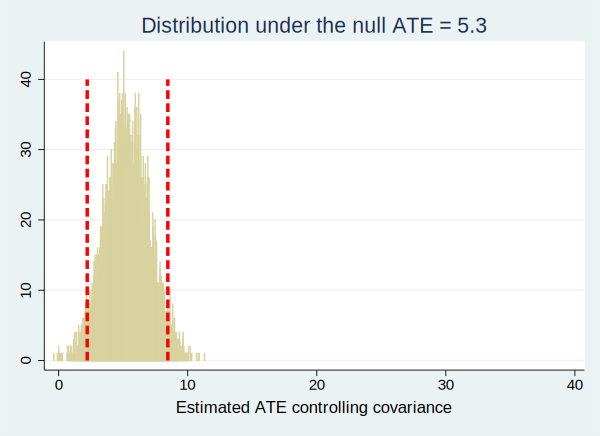





(file ./exercise_4_4_g_graph.pdf written in PDF format)



In [1]:
preserve
// CI and Hist
use "ate_null_cov.dta", clear

sort Ys_cov
global yclower= round(Ys_cov[251], .001)
global ycupper= round(Ys_cov[9750], .001)

di "95%CI: ($yclower, $ycupper)" 

graph twoway (histogram Ys_cov,frequency bin(1000)) ///
(scatteri 0 $tau_c 40 $tau_c, c(l) lc(red) lw(thick) lp(dash) m(i)) ///
(scatteri 0 $yclower 40 $yclower, c(l) lc(red) lw(thick) lp(dash) m(i)) ///
(scatteri 0 $ycupper 40 $ycupper, c(l) lc(red) lw(thick) lp(dash) m(i)), ///
legend(off) ///
b1title("Estimated ATE controlling covariance") title("Distribution under the null ATE = 5.3") ///
xtitle("")

graph export ./exercise_4_4_g_graph.pdf

restore
